# Milestone 1: Data Collection, Exploration, and Preprocessing

## Task 1: Data Collection
- We found [Store Sales - Time Series Forecasting] dataset on Kaggle
    - Link: https://www.kaggle.com/competitions/store-sales-time-series-forecasting/overview
    - Dataset Overview:
        - Files:
            - train.csv:
                - Daily sales (2013–2017) for 54 stores, 33 product families (~3M rows).
                - Columns: date, store_nbr, family (product category), sales, onpromotion (promotion quantity).
            - stores.csv:
                - Metadata for 54 stores.
                - Columns: store_nbr, city, state, type, cluster.
            - oil.csv:
                - Daily oil prices (economic indicator, as Ecuador’s economy is oil-dependent).
                - Columns: date, dcoilwtico (oil price).
            - holidays_events.csv:
                - Holiday and event data.
                - Columns: date, type (Holiday, Event, etc.), locale, locale_name, description, transferred.
            - transactions.csv: Daily transaction counts.
    - Features:
        - Covers historical sales (sales)
        - Product details (family)
        - Seasonality (holidays_events)
        - Promotions (onpromotion)
        - Economic indicators (oil)
        - Store metadata (city, state)
        

## Task 2: Data Exploration
- Step 1: Import Necessary Libraries
- Step 2: Load and Preview the dataset
- Step 3: Data Understanding (determine interesting features - check missing values - duplicates - outliers - summary statistics)

In [29]:
# Step 1: Import Necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import StandardScaler

In [ ]:
# Step 2: Load and Preview the dataset

# Load data
train = pd.read_csv('./Dataset/train.csv', parse_dates=['date'])
stores = pd.read_csv('./Dataset/stores.csv')
oil = pd.read_csv('./Dataset/oil.csv', parse_dates=['date'])
holidays = pd.read_csv('./Dataset/holidays_events.csv', parse_dates=['date'])
transactions = pd.read_csv('./Dataset/transactions.csv', parse_dates=['date'])

# Quick check
print("Train shape:", train.shape)
print(train.head())
print("Stores:", stores.head())
print("Oil:", oil.head())
print("Holidays:", holidays.head())

Train shape: (3000888, 6)
   id       date  store_nbr      family  sales  onpromotion
0   0 2013-01-01          1  AUTOMOTIVE    0.0            0
1   1 2013-01-01          1   BABY CARE    0.0            0
2   2 2013-01-01          1      BEAUTY    0.0            0
3   3 2013-01-01          1   BEVERAGES    0.0            0
4   4 2013-01-01          1       BOOKS    0.0            0
Stores:    store_nbr           city                           state type  cluster
0          1          Quito                       Pichincha    D       13
1          2          Quito                       Pichincha    D       13
2          3          Quito                       Pichincha    D        8
3          4          Quito                       Pichincha    D        9
4          5  Santo Domingo  Santo Domingo de los Tsachilas    D        4
Oil:         date  dcoilwtico
0 2013-01-01         NaN
1 2013-01-02       93.14
2 2013-01-03       92.97
3 2013-01-04       93.12
4 2013-01-07       93.20
Holiday

In [21]:
# Step 3: Data Understanding > Check Missing Values
print('----- Check Missing Values -----')
train_missing_values = train.isna().sum()
stores_missing_values = stores.isnull().sum()
oil_missing_values = oil.isnull().sum()
holidays_missing_values = holidays.isnull().sum()

print(train_missing_values, end='\n---------------------\n')
print(stores_missing_values, end='\n---------------------\n')
print(oil_missing_values, end='\n---------------------\n')
print(holidays_missing_values)

----- Check Missing Values -----
id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64
---------------------
store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64
---------------------
date           0
dcoilwtico    43
dtype: int64
---------------------
date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64


In [13]:
# Step 3: Data Understanding > Check Duplicate Rows
print('----- Check Duplicate Rows -----')
duplicate_rows = train.duplicated().sum()

print(f'Number of duplicate rows = {duplicate_rows}')

----- Check Duplicate Rows -----
Number of duplicate rows = 0


----- Check Outliers -----


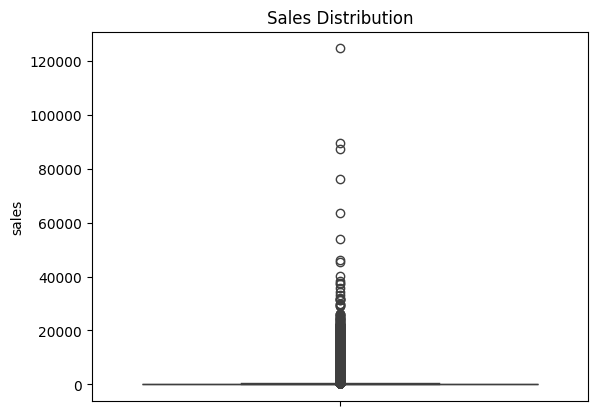

In [17]:
# Step 3: Data Understanding > Check Outliers (High sales may not be outliers [holiday spikes] & zeros are valid [no sales])
print('----- Check Outliers -----')

sns.boxplot(y=train['sales'])
plt.title('Sales Distribution')
plt.show()

## Task 3: Preprocessing and Feature Engineering
- Step 1: Merge Datasets
- Step 2: Handle Missing Data
- Step 3: Manage Outliers
- Step 4: Create relevant features like time-based and promotion flag. 

In [37]:
# Step 1: Merge Datasets

data = train.merge(stores, on='store_nbr', how='left', suffixes=('', '_store'))
data = data.merge(oil, on='date', how='left')
data = data.merge(holidays[['date', 'type']], on='date', how='left', suffixes=('', '_holiday'))

# Rename Columns
data = data.rename(columns={'type': 'holiday_type', 'type_store': 'store_type'})

# Verify
print(data.columns)


Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'city',
       'state', 'holiday_type', 'cluster', 'dcoilwtico', 'type_holiday'],
      dtype='object')


In [38]:
# Step 2: Handle Missing Data
print('----- Handle Missing Data -----')

# Handle missing oil prices
data['dcoilwtico'].fillna(data['dcoilwtico'].mean())

# Handle holidays
data['is_holiday'] = data['holiday_type'].notnull().astype(int)
data['holiday_type'] = data['holiday_type'].fillna('None')

# Verify
print(data['is_holiday'].value_counts())
print(data['holiday_type'].value_counts())

----- Handle Missing Data -----
is_holiday
1    3054348
Name: count, dtype: int64
holiday_type
D    1018116
C     848430
A     509058
B     452496
E     226248
Name: count, dtype: int64


In [39]:
# Step 3: Manage Outliers
print('----- Manage Outliers -----')

threshold = data['sales'].quantile(0.99)
data['sales_capped'] = np.where(data['sales'] > threshold, threshold, data['sales'])
# Or log-transform
data['sales_log'] = np.log1p(data['sales'])

----- Manage Outliers -----


In [40]:
# Step 4: Create Relevant Features:

# Time-based features
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day
data['day_of_week'] = data['date'].dt.dayofweek
data['week_of_year'] = data['date'].dt.isocalendar().week

# Promotion flag
data['has_promotion'] = (data['onpromotion'] > 0).astype(int)

# Lag features (per store and product family)
for lag in [1, 7, 14, 28, 365]:
    data[f'lag_{lag}'] = data.groupby(['store_nbr', 'family'])['sales'].shift(lag)

# Rolling statistics
data['rolling_mean_7'] = data.groupby(['store_nbr', 'family'])['sales'].rolling(window=7, min_periods=1).mean().reset_index(level=[0,1], drop=True)
data['rolling_mean_30'] = data.groupby(['store_nbr', 'family'])['sales'].rolling(window=30, min_periods=1).mean().reset_index(level=[0,1], drop=True)

# Encode categoricals (example: one-hot for ML models)
data = pd.get_dummies(data, columns=['family', 'city', 'state', 'holiday_type'], drop_first=True)

# Save
data.to_csv('./Dataset/processed_sales.csv', index=False)

# Check final data
print(data.head())
print(data.columns)

   id       date  store_nbr  sales  onpromotion  cluster  dcoilwtico  \
0   0 2013-01-01          1    0.0            0       13         NaN   
1   1 2013-01-01          1    0.0            0       13         NaN   
2   2 2013-01-01          1    0.0            0       13         NaN   
3   3 2013-01-01          1    0.0            0       13         NaN   
4   4 2013-01-01          1    0.0            0       13         NaN   

  type_holiday  is_holiday  sales_capped  ...  state_Manabi  state_Pastaza  \
0      Holiday           1           0.0  ...         False          False   
1      Holiday           1           0.0  ...         False          False   
2      Holiday           1           0.0  ...         False          False   
3      Holiday           1           0.0  ...         False          False   
4      Holiday           1           0.0  ...         False          False   

   state_Pichincha  state_Santa Elena  state_Santo Domingo de los Tsachilas  \
0             True 

## Task 4: Exploratory Data Analysis (EDA):
- Step 1: Create visualizations (line plots, bar charts, heatmaps)
- Step 2: Summarize key insights that could inform forecasting models.

In [60]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

# Set seaborn style for pretty visuals
sns.set_style("whitegrid")
sns.set_palette("deep")  # Vibrant, professional colors

# Load processed data (adjust path as needed)
data = pd.read_csv('./Dataset/processed_sales.csv', parse_dates=['date'], low_memory=False)

# Quick check
print(data.columns)

Index(['id', 'date', 'store_nbr', 'sales', 'onpromotion', 'cluster',
       'dcoilwtico', 'type_holiday', 'is_holiday', 'sales_capped', 'sales_log',
       'year', 'month', 'day', 'day_of_week', 'week_of_year', 'has_promotion',
       'lag_1', 'lag_7', 'lag_14', 'lag_28', 'lag_365', 'rolling_mean_7',
       'rolling_mean_30', 'family_BABY CARE', 'family_BEAUTY',
       'family_BEVERAGES', 'family_BOOKS', 'family_BREAD/BAKERY',
       'family_CELEBRATION', 'family_CLEANING', 'family_DAIRY', 'family_DELI',
       'family_EGGS', 'family_FROZEN FOODS', 'family_GROCERY I',
       'family_GROCERY II', 'family_HARDWARE', 'family_HOME AND KITCHEN I',
       'family_HOME AND KITCHEN II', 'family_HOME APPLIANCES',
       'family_HOME CARE', 'family_LADIESWEAR', 'family_LAWN AND GARDEN',
       'family_LINGERIE', 'family_LIQUOR,WINE,BEER', 'family_MAGAZINES',
       'family_MEATS', 'family_PERSONAL CARE', 'family_PET SUPPLIES',
       'family_PLAYERS AND ELECTRONICS', 'family_POULTRY',
       'fa

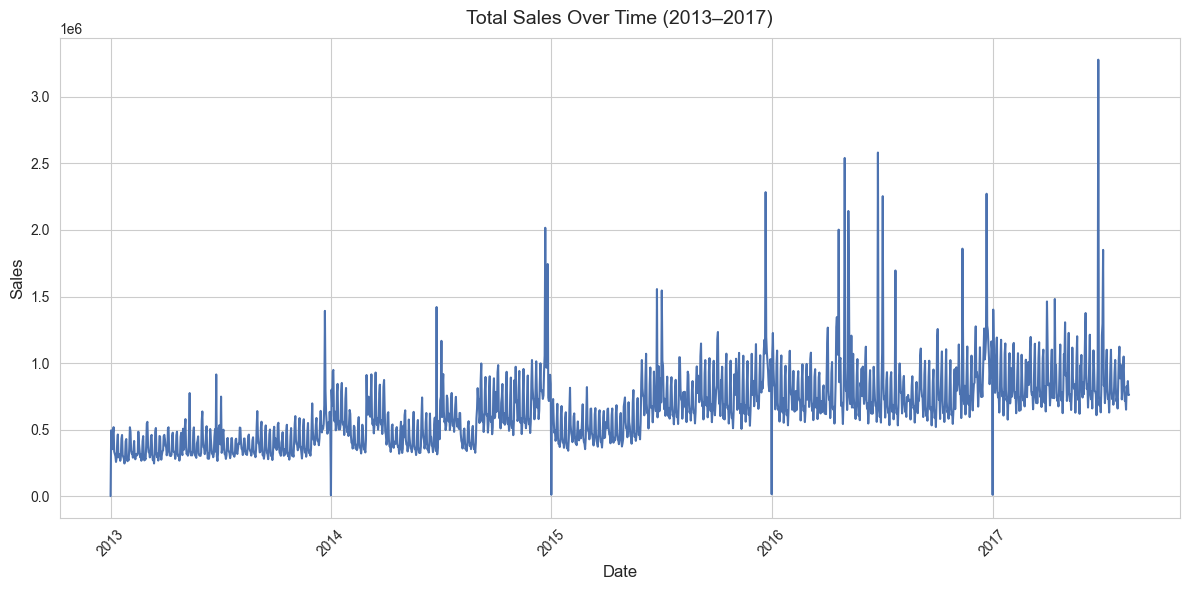

In [45]:
# Total Sales Over Time (Line Plot)

# Aggregate total sales by date
total_sales = data.groupby('date')['sales'].sum()

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(x=total_sales.index, y=total_sales.values, linewidth=1.5)
plt.title('Total Sales Over Time (2013–2017)', fontsize=14, pad=10)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sales', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('./EDA/total_sales.png')
plt.show()

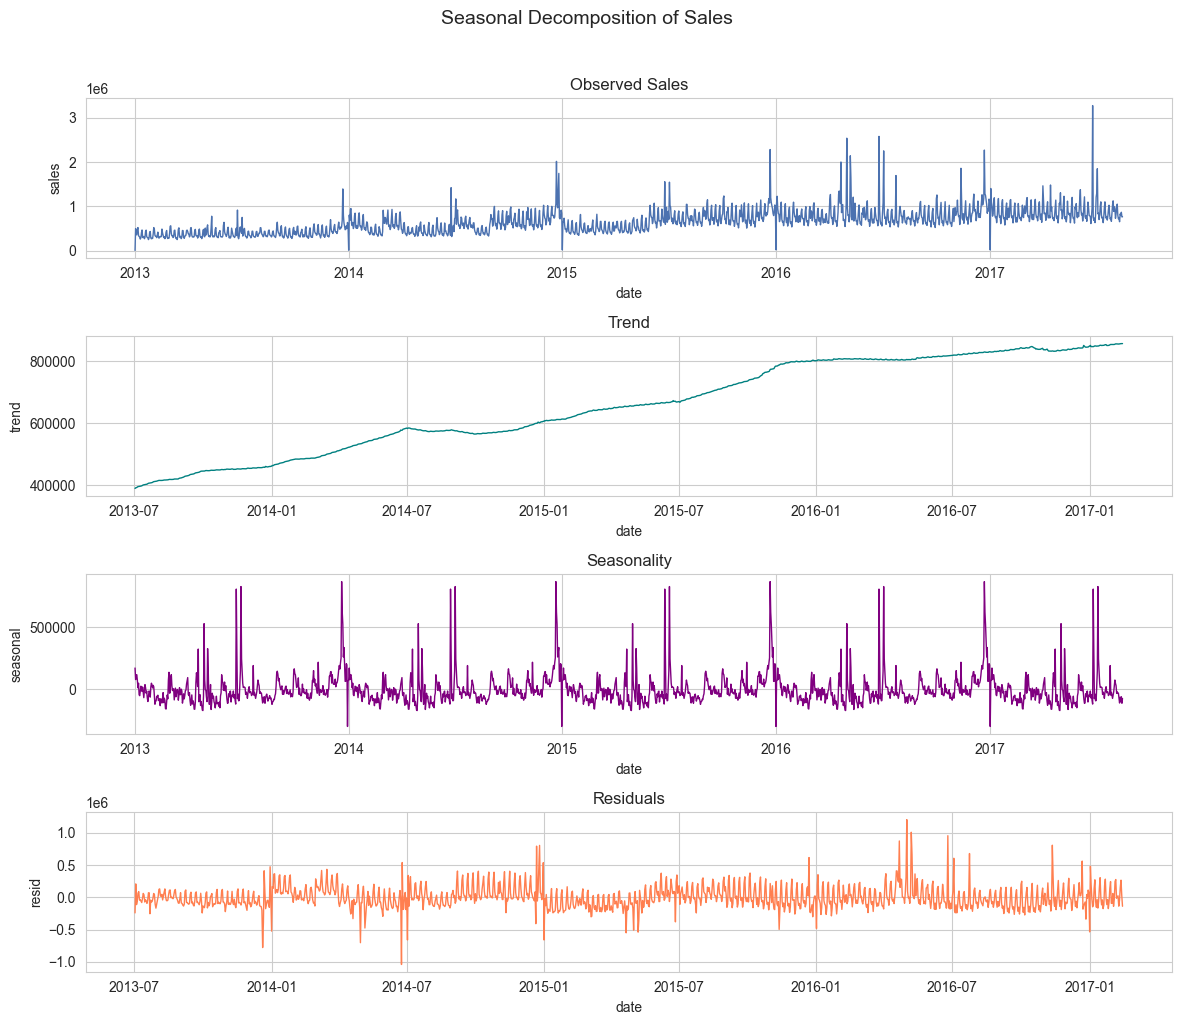

In [47]:
# Seasonal Decomposition

# Decompose (use additive model for retail sales)
decomposition = seasonal_decompose(total_sales, model='additive', period=365)

# Plot
plt.figure(figsize=(12, 10))
plt.subplot(411)
sns.lineplot(x=decomposition.observed.index, y=decomposition.observed, linewidth=1)
plt.title('Observed Sales', fontsize=12)

plt.subplot(412)
sns.lineplot(x=decomposition.trend.index, y=decomposition.trend, linewidth=1, color='teal')
plt.title('Trend', fontsize=12)

plt.subplot(413)
sns.lineplot(x=decomposition.seasonal.index, y=decomposition.seasonal, linewidth=1, color='purple')
plt.title('Seasonality', fontsize=12)

plt.subplot(414)
sns.lineplot(x=decomposition.resid.index, y=decomposition.resid, linewidth=1, color='coral')
plt.title('Residuals', fontsize=12)

plt.suptitle('Seasonal Decomposition of Sales', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('./EDA/decomposition.png')
plt.show()

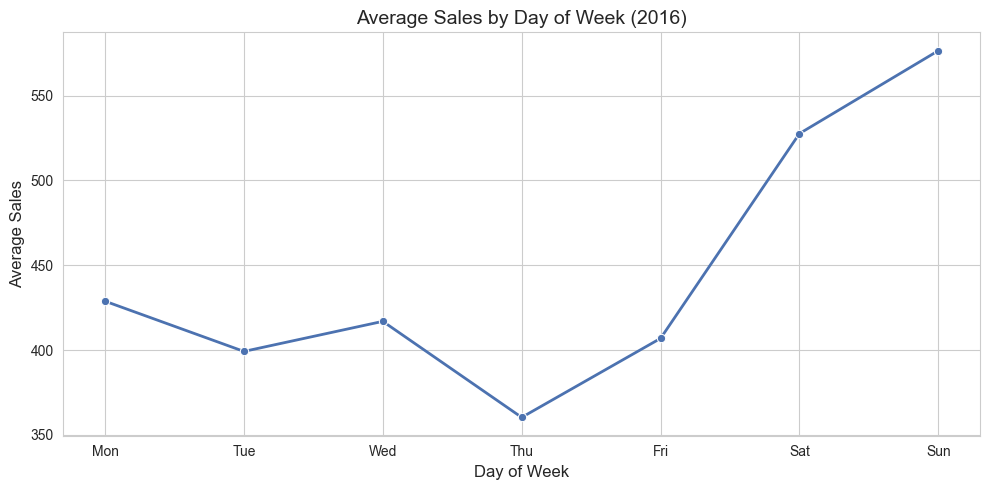

In [49]:
# Weekly Sales Pattern (Line Plot)

# Average sales by day of week (2016 for focus)
weekly_sales = data[data['year'] == 2016].groupby('day_of_week')['sales'].mean()
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

# Plot
plt.figure(figsize=(10, 5))
sns.lineplot(x=days, y=weekly_sales.values, marker='o', linewidth=2)
plt.title('Average Sales by Day of Week (2016)', fontsize=14)
plt.xlabel('Day of Week', fontsize=12)
plt.ylabel('Average Sales', fontsize=12)
plt.tight_layout()
plt.savefig('./EDA/weekly_sales.png')
plt.show()

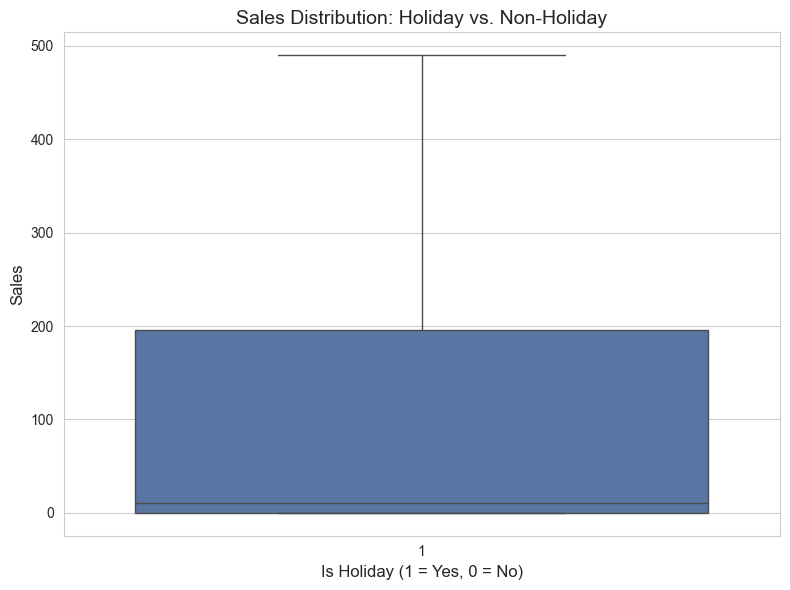

In [50]:
# Holiday vs. Non-Holiday Sales (Box Plot)

# Plot
plt.figure(figsize=(8, 6))
sns.boxplot(x='is_holiday', y='sales', data=data, showfliers=False)
plt.title('Sales Distribution: Holiday vs. Non-Holiday', fontsize=14)
plt.xlabel('Is Holiday (1 = Yes, 0 = No)', fontsize=12)
plt.ylabel('Sales', fontsize=12)
plt.tight_layout()
plt.savefig('./EDA/holiday_sales.png')
plt.show()

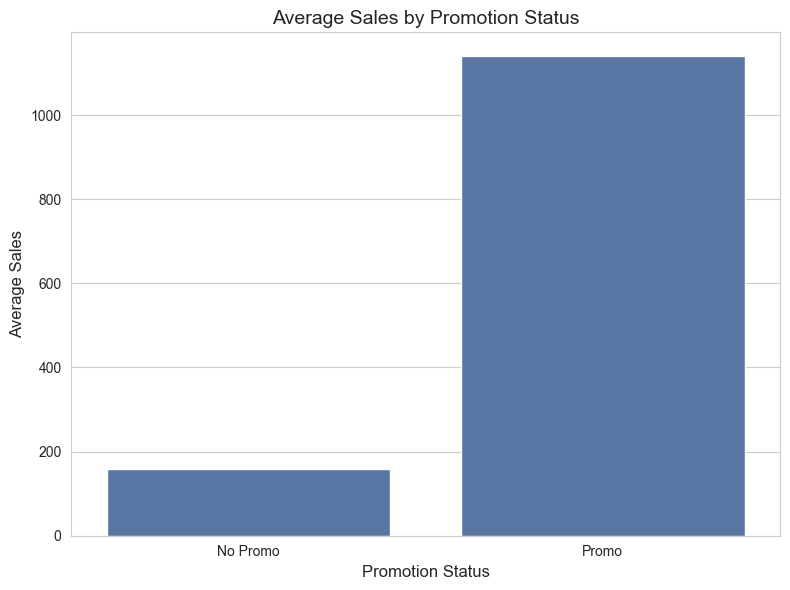

In [52]:
# Promotion Impact (Bar Plot)

# Average sales by promotion status
promo_sales = data.groupby('has_promotion')['sales'].mean().reset_index()
promo_sales['has_promotion'] = promo_sales['has_promotion'].map({0: 'No Promo', 1: 'Promo'})

# Plot
plt.figure(figsize=(8, 6))
sns.barplot(x='has_promotion', y='sales', data=promo_sales)
plt.title('Average Sales by Promotion Status', fontsize=14)
plt.xlabel('Promotion Status', fontsize=12)
plt.ylabel('Average Sales', fontsize=12)
plt.tight_layout()
plt.savefig('./EDA/promo_sales.png')
plt.show()

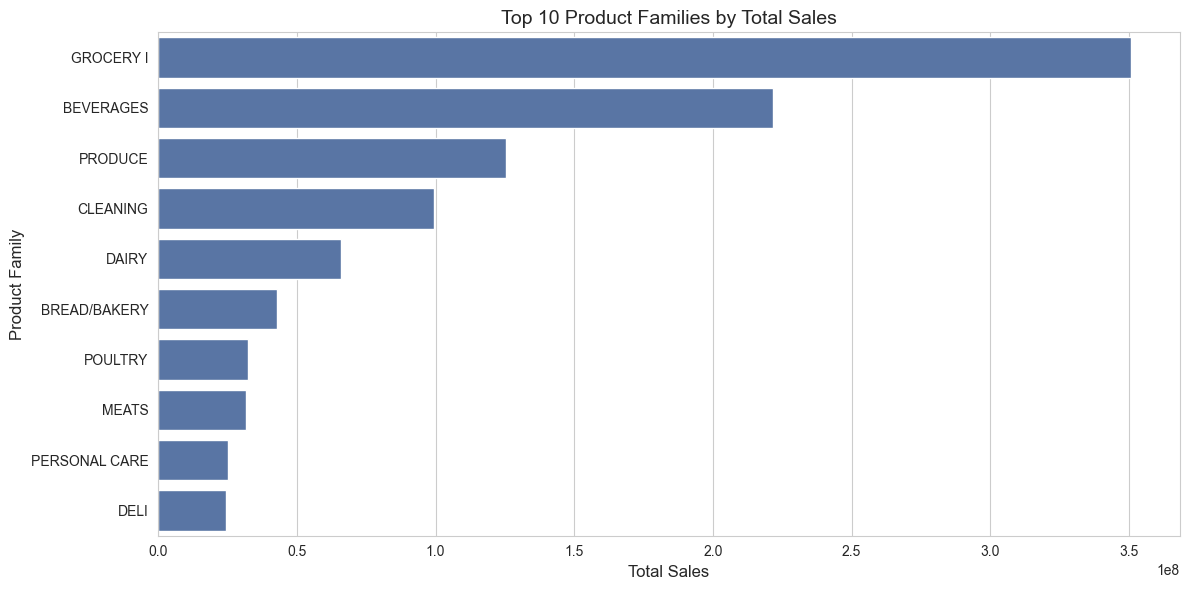

In [62]:
# Sales by Product Family (Bar Plot)

# Identify family dummy columns
family_cols = [col for col in data.columns if col.startswith('family_')]

# Calculate sales per family
family_sales = pd.DataFrame()
for col in family_cols:
    family_name = col.replace('family_', '')
    total = data.loc[data[col] == 1, 'sales'].sum()
    family_sales = pd.concat([family_sales, pd.DataFrame({'family': [family_name], 'sales': [total]})])

# Sort and reset
family_sales = family_sales.sort_values('sales', ascending=False).reset_index(drop=True)

# Plot top 10
plt.figure(figsize=(12, 6))
sns.barplot(x='sales', y='family', data=family_sales.head(10))
plt.title('Top 10 Product Families by Total Sales', fontsize=14)
plt.xlabel('Total Sales', fontsize=12)
plt.ylabel('Product Family', fontsize=12)
plt.tight_layout()
plt.savefig('./EDA/family_sales.png')
plt.show()

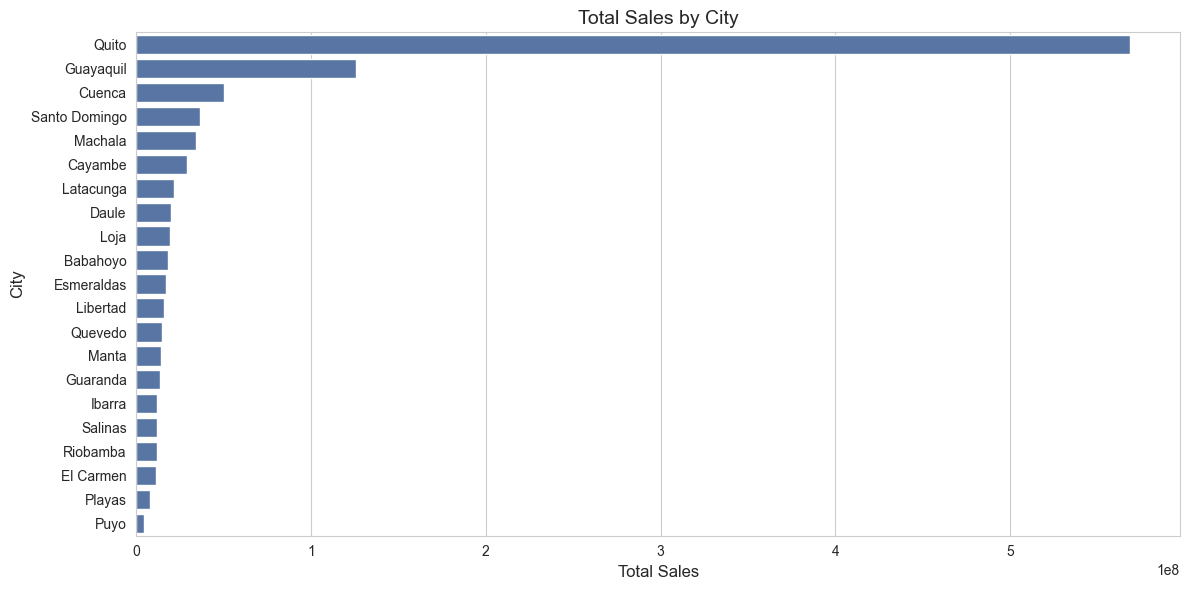

In [65]:
# Sales by Store City (Bar Plot)

# Identify city dummy columns
city_cols = [col for col in data.columns if col.startswith('city_')]

# Calculate sales per city
city_sales = pd.DataFrame()
for col in city_cols:
    city_name = col.replace('city_', '')
    total = data.loc[data[col] == 1, 'sales'].sum()
    city_sales = pd.concat([city_sales, pd.DataFrame({'city': [city_name], 'sales': [total]})])

# Sort and reset
city_sales = city_sales.sort_values('sales', ascending=False).reset_index(drop=True)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x='sales', y='city', data=city_sales)
plt.title('Total Sales by City', fontsize=14)
plt.xlabel('Total Sales', fontsize=12)
plt.ylabel('City', fontsize=12)
plt.tight_layout()
plt.savefig('./EDA/city_sales.png')
plt.show()

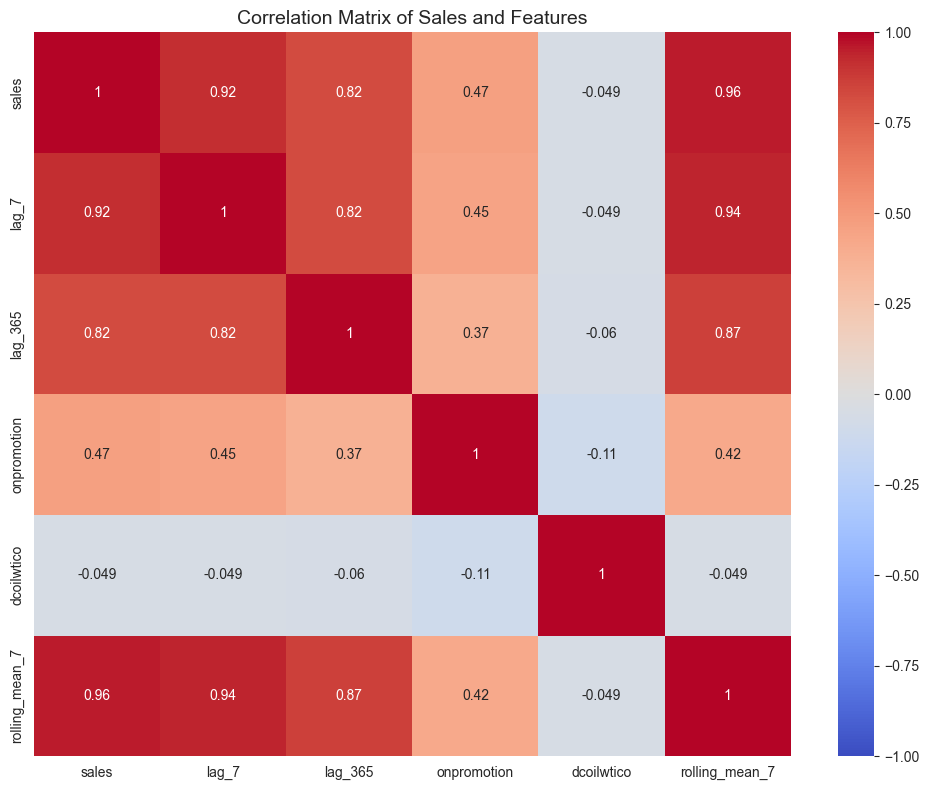

In [55]:
# Correlation Heatmap

# Select numerical features
corr_data = data[['sales', 'lag_7', 'lag_365', 'onpromotion', 'dcoilwtico', 'rolling_mean_7']].dropna()

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(corr_data.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Matrix of Sales and Features', fontsize=14)
plt.tight_layout()
plt.savefig('./EDA/correlation.png')
plt.show()

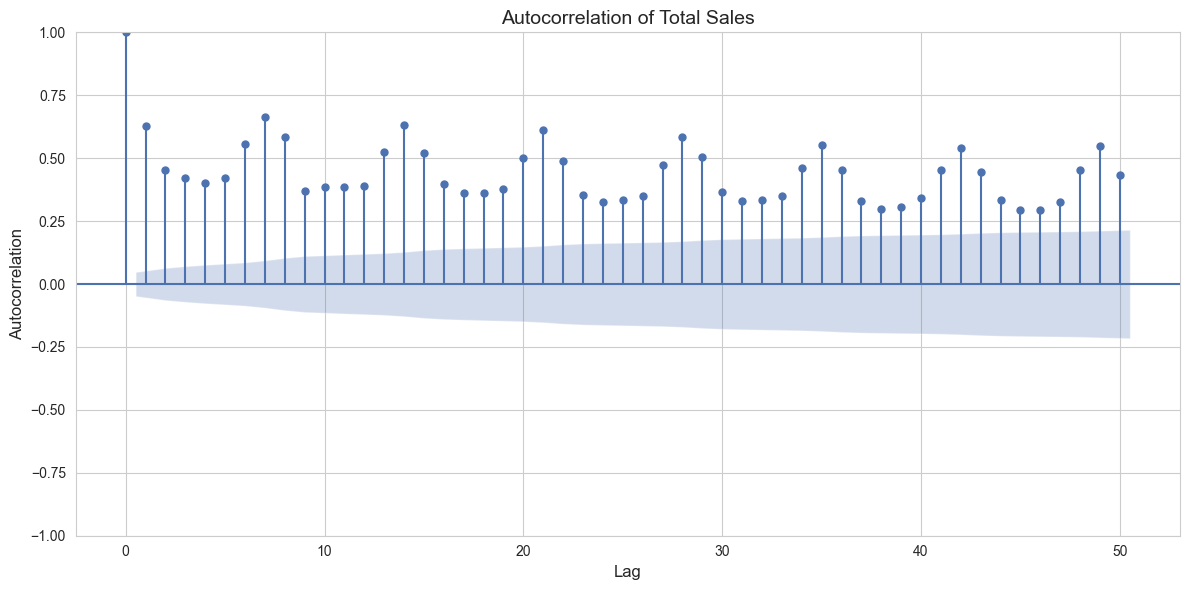

In [56]:
# Autocorrelation Plot

# Plot ACF for total sales
plt.figure(figsize=(12, 6))
plot_acf(total_sales, lags=50, ax=plt.gca())
plt.title('Autocorrelation of Total Sales', fontsize=14)
plt.xlabel('Lag', fontsize=12)
plt.ylabel('Autocorrelation', fontsize=12)
plt.tight_layout()
plt.savefig('./EDA/acf.png')
plt.show()

In [58]:
# Summarizing Insights

insights = """
# EDA Visualization Insights
- **Trends**: Sales show a slight upward trend from 2013–2017, with notable growth in 2016.
- **Seasonality**: Strong yearly peaks in December (holidays); weekly spikes on weekends.
- **Holidays**: Holiday sales are significantly higher and more variable than non-holiday.
- **Promotions**: Promotions double average sales, critical for marketing strategies.
- **Products**: 'GROCERY I' and 'BEVERAGES' dominate; 'BOOKS' has low sales.
- **Cities**: Quito and Guayaquil lead sales; smaller cities lag.
- **Correlations**: Lag_7 and rolling_mean_7 strongly predict sales; oil prices weakly correlated.
- **Autocorrelation**: Significant lags at 7, 14, and 365 days, suggesting weekly and yearly patterns.
"""
with open('./EDA/insights.md', 'w') as f:
    f.write(insights)